In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv
from supervenn import supervenn
import os
from scipy import stats
from biomart import BiomartServer
import io
from matplotlib import rcParams

## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
def scale_bp_by_chromosome(df):
    """
    Scales the 'BP' column in a dataframe by dividing each entry by the maximum 'BP' entry 
    for the respective chromosome and then multiplying by 1,000,000.

    Parameters:
    df (pd.DataFrame): A dataframe containing at least two columns: 
                       'CHR' for chromosome and 'BP' for base pair positions.

    Returns:
    pd.DataFrame: A dataframe with the 'BP' column scaled for each chromosome, 
                  with a new 'Scaled_BP' column added.
    """
    # Ensure the dataframe has the necessary columns
    if 'CHR' not in df.columns or 'BP' not in df.columns:
        raise ValueError("Dataframe must contain 'CHR' and 'BP' columns")

    # Create a copy of the dataframe to avoid modifying the original one
    df_copy = df.copy()

    # Create a new column 'Scaled_BP' to store the scaled values
    df_copy['BP'] = df_copy.groupby('CHR')['BP'].apply(lambda x: round((x / x.max()) * 1_000_000, 0)).reset_index(level=0, drop=True)
    
    return df_copy


In [3]:
def parse_gtf_file(gtf_file_path):
    """
    Extracts gene_id, start_position, and chromosome information from a GTF file.

    Parameters:
    gtf_file_path (str): The file path to the GTF file.

    Returns:
    pd.DataFrame: A DataFrame containing the columns ["gene_id", "start_position", "chr"].
    """
    # Read the GTF file into a DataFrame
    gtf_df = pd.read_csv(gtf_file_path, sep='\t', comment='#', header=None, low_memory=False,
                         names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    
    ## Only keep gene entries
    gtf_df = gtf_df.loc[gtf_df["feature"] == "gene"].copy()
    
    # Extract the gene_id from the attribute column
    gtf_df['gene_id'] = gtf_df['attribute'].str.extract('gene_id "([^"]+)"')
    
    # Select the useful columns
    useful_columns = gtf_df[['gene_id', 'start', 'seqname']].copy().drop_duplicates()
    
    # Rename the columns to the desired names
    useful_columns.columns = ['gene_id', 'start_position', 'chr']
    
    return useful_columns

In [4]:
def manhattan_plot(df, title='Manhattan Plot', significance_line=-np.log10(5e-8), highlight_colors={'up': '#F8766D', 'down': '#00BFC4'}, 
                   highlight_genes=None, ylabel = "-log10(P-value)", 
                   output_path = "./output"):
    """
    Create a Manhattan plot using matplotlib and seaborn.
    
    Parameters:
    - df: DataFrame containing at least 'CHR', 'BP', 'P', and 'regulation' columns.
    - title: Title of the plot.
    - significance_line: The y-value (in -log10(p-value) scale) where the significance line is drawn.
    - highlight_colors: Dictionary with colors for upregulated and downregulated genes.
    - highlight_genes: List of specific genes to highlight. If None, all significant genes are highlighted.
    """
    
    mm = (1/25.4)
    
    # figure size in millimiters
    plt.figure(figsize=(180*mm, 90*mm))  # Set the figure size in inches (width, height)
    plt.rcParams.update({'font.size': 7})  # Set the font size for the entire figure
    
    # Standard human chromosomes
    standard_chromosomes = [str(i) for i in range(1, 23)] + ['X', 'Y', 'MT']
    
    # Classify non-standard chromosomes as "contigs"
    df['CHR'] = df['CHR'].apply(lambda x: x if str(x) in standard_chromosomes else 'contigs')
    
    # Ensure the chromosomes are ordered correctly
    chromosome_order = [str(i) for i in range(1, 23)] + ['X', 'Y', 'MT', 'contigs']
    df['CHR'] = pd.Categorical(df['CHR'], categories=chromosome_order, ordered=True)
    
    # Ensure the data is sorted by chromosome and base pair position
    df = df.sort_values(['CHR', 'BP'])
    
    # Create a new column for -log10(p-value)
    df['-log10(P)'] = -np.log10(df['P'])
    
    # Filter out any rows with non-finite values in BP or -log10(P)
    df = df[np.isfinite(df['BP']) & np.isfinite(df['-log10(P)'])]
    
    # Set up the plot
    sns.set(style="white")
    
    # Define shades of gray for different chromosomes
    colors = ['#b0b0b0', '#707070']  # Light and dark gray for alternating chromosomes
    
    # Create an empty plot
    ax = plt.gca()
    ax.grid(False)  # Disable grid lines
    
    # Plot each chromosome with alternating colors
    x_labels = []
    x_labels_pos = []
    last_max_bp = 0
    chr_offsets = {}  # Dictionary to store the offset for each chromosome
    for i, (chr_num, chr_df) in enumerate(df.groupby('CHR', observed=True)):
        chr_offsets[chr_num] = last_max_bp  # Store the offset for each chromosome
        chr_df['BP'] = chr_df['BP'].astype(float) + last_max_bp  # Convert BP to float and shift BP positions
        ax.scatter(chr_df['BP'], chr_df['-log10(P)'], 
                   color=colors[i % len(colors)], s=10, alpha=0.6)
        x_labels.append(f'{chr_num}')
        x_labels_pos.append((chr_df['BP'].max() + chr_df['BP'].min()) / 2)
        last_max_bp = chr_df['BP'].max()  # Update the last maximum BP position
    
    # Add significance line
    if significance_line:
        plt.axhline(y=significance_line, color='black', linestyle='--', linewidth=1)
    
    # Highlight genes that pass the significance threshold
    significant_genes = df[df['-log10(P)'] >= significance_line]
    significant_genes.loc[:, 'CHR'] = significant_genes['CHR'].astype(str)  # Convert CHR to string
    significant_genes.loc[:, 'BP'] = significant_genes['BP'].astype(float)  # Convert BP to float
    significant_genes.loc[:, 'BP'] += significant_genes['CHR'].map(chr_offsets).astype(float)  # Adjust the BP positions for significant genes
    
    # Filter significant genes if highlight_genes is provided
    if highlight_genes is not None:
        significant_genes = significant_genes[significant_genes['gene'].isin(highlight_genes)]
    
    # Plot upregulated and downregulated significant genes
    upregulated_genes = significant_genes[significant_genes['regulation'] == 'Upregulated in AD']
    downregulated_genes = significant_genes[significant_genes['regulation'] == 'Downregulated in AD']
    
    ax.scatter(upregulated_genes['BP'], upregulated_genes['-log10(P)'], 
               color=highlight_colors['up'], s=15, label='Upregulated in AD')
    ax.scatter(downregulated_genes['BP'], downregulated_genes['-log10(P)'], 
               color=highlight_colors['down'], s=15, label='Downregulated in AD')
    
    # Adding gene labels for significant points (assuming 'gene' column exists in the dataframe)
    if 'gene' in df.columns:
        for i, row in significant_genes.iterrows():
            # Adjust the BP position based on the chromosome offset
            ax.text(row['BP'], row['-log10(P)'], row['gene'], fontsize=7, fontweight='bold')
    
    # Customize plot
    plt.xlabel('Chromosome', fontsize=7)
    plt.ylabel(ylabel, fontsize=7)
    plt.xticks(x_labels_pos, x_labels, rotation=45, fontsize=7)
    plt.yticks(fontsize=7)
    
    # Custom legend
    handles, labels = ax.get_legend_handles_labels()
    custom_handles = [handles[-2], handles[-1]]  # Only take the last two handles (upregulated and downregulated)
    custom_labels = [labels[-2], labels[-1]]  # Only take the last two labels
    plt.legend(custom_handles, custom_labels, fontsize=7)
    
    # Show plot
    plt.tight_layout()
    output_png = output_path + ".png"
    output_pdf = output_path + ".pdf"
    plt.savefig(output_png,
                dpi=1200, transparent=True, bbox_inches="tight")
    plt.savefig(output_pdf,
                dpi=1200, transparent=True, bbox_inches="tight")
    plt.show()
    plt.close()

In [5]:
## Import all the data from the different meta analyses
df_temporal = pd.read_csv("../../data/processed_data/temporal_lobe/RESULTS_temporal_lobe_meta-analysis_adjusted_p-values1.tsv", sep="\t")
df_frontal = pd.read_csv("../../data/processed_data/frontal_lobe/RESULTS_frontal_lobe_meta-analysis_adjusted_p-values1.tsv", sep="\t")

In [6]:
## Only keep genes that have no missing studies
print("Originally the temporal lobe meta-analysis was performed on", str(df_temporal.shape[0]), "genes")

df_temporal = df_temporal.loc[~df_temporal["Direction"].str.contains(r"\?", na=False)].copy()

print("\nAfter filtering out genes that were missing in any study, we were left with", str(df_temporal.shape[0]), "genes")

Originally the temporal lobe meta-analysis was performed on 37830 genes

After filtering out genes that were missing in any study, we were left with 32093 genes


In [7]:
## Only keep genes that have no missing studies
print("Originally the frontal lobe meta-analysis was performed on", str(df_frontal.shape[0]), "genes")

df_frontal = df_frontal.loc[~df_frontal["Direction"].str.contains(r"\?", na=False)].copy()

print("\nAfter filtering out genes that were missing in any study, we were left with", str(df_frontal.shape[0]), "genes")

Originally the frontal lobe meta-analysis was performed on 38288 genes

After filtering out genes that were missing in any study, we were left with 32955 genes


In [8]:
## Get proper gene symbol and ensembl_id
df_temporal["gene_symbol"] = df_temporal["MarkerName"].str.split("|", expand=True)[1]
df_temporal["gene_id"] = df_temporal["MarkerName"].str.split("|", expand=True)[0]

df_frontal["gene_symbol"] = df_frontal["MarkerName"].str.split("|", expand=True)[1]
df_frontal["gene_id"] = df_frontal["MarkerName"].str.split("|", expand=True)[0]

In [9]:
## Get chromosome and start position information for every remaining gene based on ensembl_id and biomart
gtf = parse_gtf_file("../../references/Homo_sapiens.GRCh38.110.gtf")

In [10]:
## Get relevant gene information into dataframes

df_temporal = df_temporal.merge(gtf, on="gene_id", how="inner")
df_frontal = df_frontal.merge(gtf, on="gene_id", how="inner")

In [11]:
## Only keep genes that have no missing studies
print("\nAfter filtering out genes that were missing information in temporal cortex, we were left with", str(df_temporal.shape[0]), "genes")
print("\nAfter filtering out genes that were missing information in frontal cortex, we were left with", str(df_frontal.shape[0]), "genes")


After filtering out genes that were missing information in temporal cortex, we were left with 29208 genes

After filtering out genes that were missing information in frontal cortex, we were left with 30008 genes


In [12]:
## Add information about regulation to temporal lobe
df_temporal.loc[((df_temporal["Zscore"] < 0) & (df_temporal["P-value"] <= 0.01/df_temporal.shape[0])), "regulation"] = "Downregulated in AD"
df_temporal.loc[((df_temporal["Zscore"] > 0) & (df_temporal["P-value"] <= 0.01/df_temporal.shape[0])), "regulation"] = "Upregulated in AD"
df_temporal.loc[df_temporal["P-value"] > 0.01/df_temporal.shape[0], "regulation"] = "Not differentially expressed"

In [13]:
## Add information about regulation to frontal lobe
df_frontal.loc[((df_frontal["Zscore"] < 0) & (df_frontal["P-value"] <= 0.01/df_frontal.shape[0])), "regulation"] = "Downregulated in AD"
df_frontal.loc[((df_frontal["Zscore"] > 0) & (df_frontal["P-value"] <= 0.01/df_frontal.shape[0])), "regulation"] = "Upregulated in AD"
df_frontal.loc[df_frontal["P-value"] > 0.01/df_frontal.shape[0], "regulation"] = "Not differentially expressed"

In [14]:
## Create dataframe to make manhathan plot for frontal and temporal lobes
df_make_manhathan_plot_frontal = pd.DataFrame()
df_make_manhathan_plot_frontal["CHR"] = df_frontal["chr"].copy()
df_make_manhathan_plot_frontal["BP"] = df_frontal["start_position"].copy()
df_make_manhathan_plot_frontal["P"] = df_frontal["P-value"].copy()
df_make_manhathan_plot_frontal["gene"] = df_frontal["gene_symbol"].copy()
df_make_manhathan_plot_frontal["regulation"] = df_frontal["regulation"].copy()
df_make_manhathan_plot_frontal = scale_bp_by_chromosome(df_make_manhathan_plot_frontal)


df_make_manhathan_plot_temporal = pd.DataFrame()
df_make_manhathan_plot_temporal["CHR"] = df_temporal["chr"].copy()
df_make_manhathan_plot_temporal["BP"] = df_temporal["start_position"].copy()
df_make_manhathan_plot_temporal["P"] = df_temporal["P-value"].copy()
df_make_manhathan_plot_temporal["gene"] = df_temporal["gene_symbol"].copy()
df_make_manhathan_plot_temporal["regulation"] = df_temporal["regulation"].copy()
df_make_manhathan_plot_temporal = scale_bp_by_chromosome(df_make_manhathan_plot_temporal)

In [15]:
## Highlight specific genes relevant to Alzheimer's

frontal_genes = ['ECE1', 'GFAP', 'SELE', 'SLC4A11', 'SLC6A9', 'ADAM33', 'OTOGL', 'CDH23', 'JUP',
                 'SLC6A12', 'APOD', 'FOXO4', 'ADAMTS2', 'TNFRSF11A', 'RIMS1', 'CXCR4', 'LLGL1', 
                 'TBX3', 'FANCE', 'CRH', 'PRX', 'NPPA', 'CHST6', "MEIS3", "PADI2", "LTF"]

temporal_genes = ['NICN1', 'GPNMB', 'IRF2', 'ICA1', 'MEX3C', 'LHFPL2', 'FOXF1', 'CR1', 'FYN',
                 'GRIA3', 'DPP6', 'RPS6KL1', 'CLU', 'OLFM1', 'ADAMTS1', 'ABCA1', 'PTPRR', 'RAB29', "NPNT",
                 "SLC7A2", "ANO6", "ECM2", "WWTR1", "GFAP", "BMP5", "RPH3A", "CORT", "SST", "CRH"]

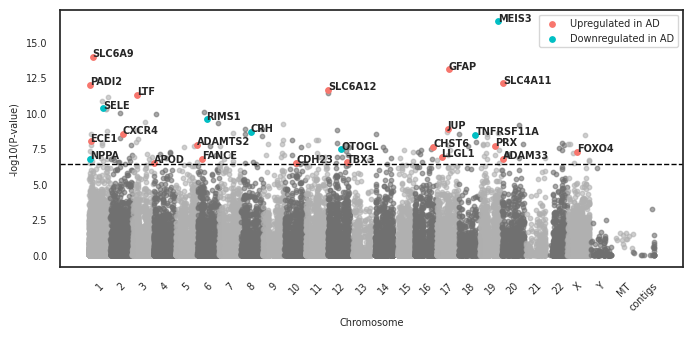

In [16]:
manhattan_plot(df_make_manhathan_plot_frontal, significance_line=-np.log10((0.01/df_make_manhathan_plot_temporal.shape[0])), 
               ylabel="-log10(P-value)", highlight_genes=frontal_genes,
              output_path="../../figures/frontal_lobe_manhathan_plot")

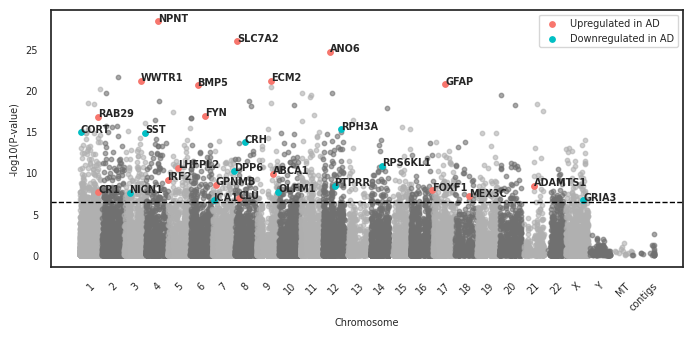

In [17]:
manhattan_plot(df_make_manhathan_plot_temporal, significance_line=-np.log10((0.01/df_make_manhathan_plot_temporal.shape[0])), 
               ylabel="-log10(P-value)", highlight_genes=temporal_genes, 
               output_path="../../figures/temporal_lobe_manhathan_plot")

In [18]:
## Create output dataframes
df_temporal_output = df_temporal[["chr", "gene_id", "gene_symbol", "P-value", "Zscore", "Direction", "regulation"]].copy()
df_frontal_output = df_frontal[["chr", "gene_id", "gene_symbol", "P-value", "Zscore", "Direction", "regulation"]].copy()

In [19]:
## Output the dataframe
df_temporal_output.to_csv("../../data/processed_data/temporal_lobe/temporal_lobe_meta-analysis_processed_results.tsv", sep="\t", index=False)
df_frontal_output.to_csv("../../data/processed_data/frontal_lobe/frontal_lobe_meta-analysis_processed_results.tsv", sep="\t", index=False)